In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
pc1 = np.genfromtxt('pc1.csv', delimiter=',')
pc2 = np.genfromtxt('pc2.csv', delimiter=',')


In [3]:
def get_covariance(dim1, dim2):
    
    mean1 = np.mean(dim1)
    mean2 = np.mean(dim2)
    
    var = (dim1 - mean1).T@(dim2 - mean2)
    
    var = var/dim1.shape[0]
    return var

In [4]:
def gen_covariance_matrix(dataset):
    
    dim1 = dataset[:, 0]
    dim2 = dataset[:, 1]
    dim3 = dataset[:, 2]
    
    sxx = get_covariance(dim1, dim1)
    sxy = get_covariance(dim1, dim2)
    sxz = get_covariance(dim1, dim3)
    
    syy = get_covariance(dim2, dim2)
    syz = get_covariance(dim2, dim3)
    
    szz = get_covariance(dim3, dim3)
    
    cov = np.array(
        [
            [sxx, sxy, sxz],
            [sxy, syy, syz],
            [sxz, syz, szz]
        ]
    )
    
    return cov


In [5]:
def get_smallest_eigs(cov):

    eigvals, eigvecs = np.linalg.eig(cov)
    # print(eigvals)
    # print(eigvecs)


    min_eigval = eigvals[0]
    surface_normal = eigvecs[0]

    for i in range(len(eigvals)):
        if eigvals[i] < min_eigval:
            min_eigval = eigvals[i]
            surface_normal = eigvecs[i]

    print(min_eigval)
    print(surface_normal)
    
    return surface_normal


In [6]:
print("Finding the surface normal using the covariance matrices for pc1")
cov1 = gen_covariance_matrix(pc1)
get_smallest_eigs(cov1)


print("\nFinding the surface normal using the covariance matrices for pc2")
cov2 = gen_covariance_matrix(pc2)
get_smallest_eigs(cov2)


Finding the surface normal using the covariance matrices for pc1
0.6672780805108687
[ 0.28616428  0.90682723 -0.30947435]

Finding the surface normal using the covariance matrices for pc2
3.630065783930771
[-0.22107409 -0.94273108 -0.2497686 ]


array([-0.22107409, -0.94273108, -0.2497686 ])

In [7]:
def plane_from_points(dataset):

    # choose 3 points randomly to form a plane
    choices = np.random.choice(dataset.shape[0], 3, replace=False)

    pt1 = dataset[choices[0], :]
    pt2 = dataset[choices[1], :]
    pt3 = dataset[choices[2], :]

    # find 2 coplanar vectors
    vect1 = pt1 - pt2
    vect2 = pt1 - pt3

    # find the surface normal to the plane
    norm = np.cross(vect1, vect2)

    # generate the planar parameters
    a = norm[0]
    b = norm[1]
    c = norm[2]
    d = norm@pt1
    
    return a, b, c, d


In [8]:
def find_outliers(dataset, a, b, c, d, thresh):
    
    inliers = []
    outliers = []
    
    for entry in dataset:
        xi = entry[0]
        yi = entry[1]
        zi = entry[2]
        
        normal_distance = abs(a*xi + b*yi + c*zi - d)/np.sqrt(a**2 + b**2 + c**2)
        
        if normal_distance <= thresh:
            inliers.append(entry)
        else:
            outliers.append(entry)
            
    inliers = np.array(inliers).reshape(-1, 3)
    outliers = np.array(outliers).reshape(-1, 3)
            
    return inliers, outliers

In [9]:
def plot_3d(ax, dataset, config, color):

    ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c = color)
    
    xx, yy = np.meshgrid(range(-10, 10), range(-10, 10))
    
    a, b, c, d = config
    z = lambda x_i, y_i: (d - a*x_i - b*y_i)/c
    zz = z(xx, yy)
    ax.plot_surface(xx, yy, zz, alpha = 0.5)


In [10]:
def ransac(dataset, e, thresh):
    s = 3
    p = 0.95
    
    # number of iterations to follow
    num_iters = np.ceil(np.log(1-p)/np.log(1-(1-e)**s))
    print(f"Estimated outlier ratio of {e*100}%, and an outlier threshold of {thresh}")
    print(f"{num_iters} iterations will be completed")
    
    
    best_config = []
    best_inliers = []
    best_outliers = []
    
    # at every iteration, pick three points at random to generate a plane
    # then compute the perpendicular distance to plane at each point and select the inliers
    # keep the plane configuration with the highest number of inliers
    for n in range(int(num_iters)):

        a, b, c, d = plane_from_points(dataset)
                
        # plot_3d(ax, pc1, z, 'b')        
        inliers, outliers = find_outliers(dataset, a, b, c, d, thresh)
        
        if len(inliers) > len(best_inliers):
            best_config = [a, b, c, d]
            best_inliers = inliers
            best_outliers = outliers
            
    return best_config, best_inliers, best_outliers
        
    

Estimated outlier ratio of 70.0%, and an outlier threshold of 0.5
110.0 iterations will be completed


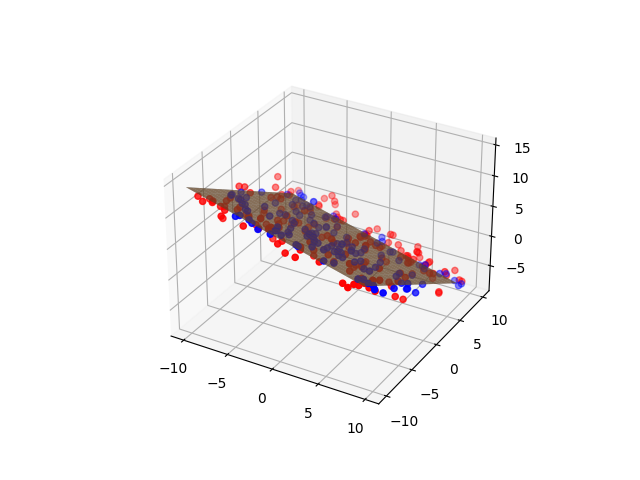

In [11]:
%matplotlib ipympl

config, inliers, outliers = ransac(pc1, 0.7, 0.5)


ax = plt.figure().add_subplot(projection='3d')
plot_3d(ax, inliers, config, 'b')
plot_3d(ax, outliers, config, 'r')


Estimated outlier ratio of 70.0%, and an outlier threshold of 0.5
110.0 iterations will be completed


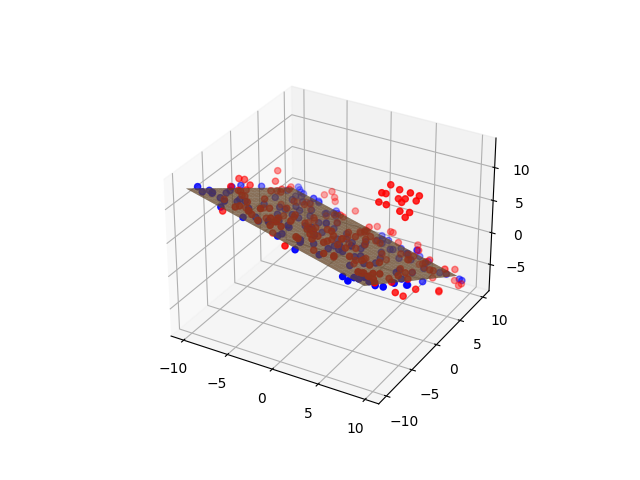

In [12]:
%matplotlib ipympl

config, inliers, outliers = ransac(pc2, 0.7, 0.5)


ax = plt.figure().add_subplot(projection='3d')
plot_3d(ax, inliers, config, 'b')
plot_3d(ax, outliers, config, 'r')

In [13]:

def ols(dataset):
    Z = deepcopy(dataset[:, 2]).reshape(-1, 1)
    X = deepcopy(dataset).reshape(-1, 3)
    X[:, -1] = 1
    D = np.linalg.inv(X.T@X)@(X.T@Z)

    ac = -1*D[0][0]
    bc = -1*D[1][0]
    dc = 1*D[2][0]

    config = (ac, bc, 1, dc)
    print(config)
    return config



(0.35395482408123236, 0.6685514549381811, 1, 3.2025536281246323)


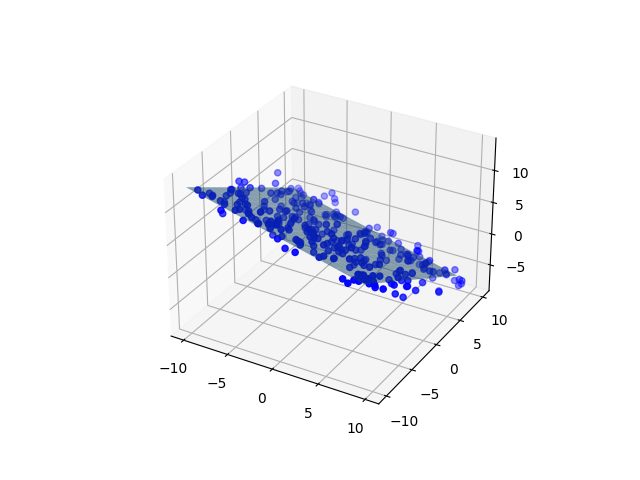

In [14]:
%matplotlib ipympl

config = ols(pc1)
ax = plt.figure().add_subplot(projection='3d')
plot_3d(ax, pc1, config, 'b')

(0.251884042864901, 0.6717366909532277, 1, 3.6602566932328706)


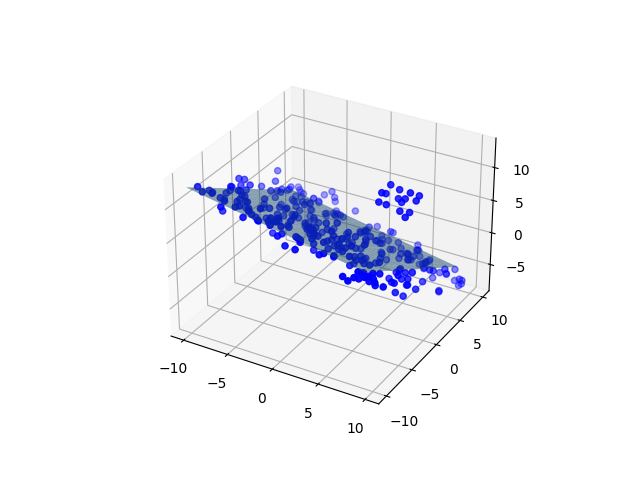

In [15]:
%matplotlib ipympl

config = ols(pc2)
ax = plt.figure().add_subplot(projection='3d')
plot_3d(ax, pc2, config, 'b')

In [16]:
def tls(dataset):
    
    a = np.zeros(shape = (dataset.shape[0], 4))
    a[:, :3] = deepcopy(dataset)
    a[:, 3] = -1

    eigvals, eigvecs = np.linalg.eig(a.T@a)

    idx = np.argmin(eigvals)
    
    surface_normal = eigvecs[:, idx]
    
    a = surface_normal[0]
    b = surface_normal[1]
    c = surface_normal[2]
    d = surface_normal[3]
    
    conf = (a, b, c, d)
    
    return conf

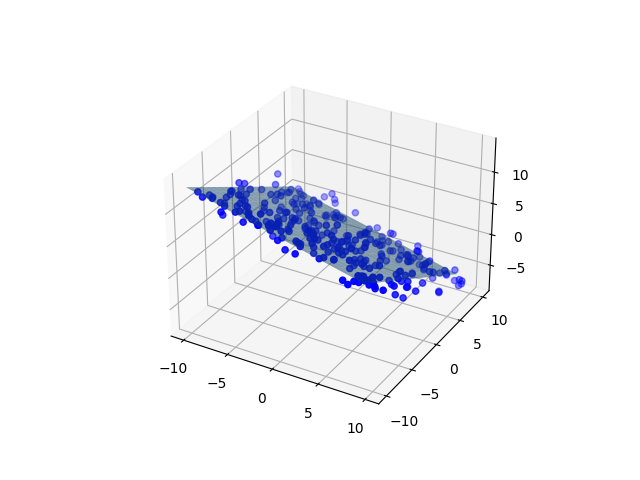

In [17]:
%matplotlib ipympl

ax = plt.figure().add_subplot(projection='3d')

conf = tls(pc1)
plot_3d(ax, pc1, conf, 'b')


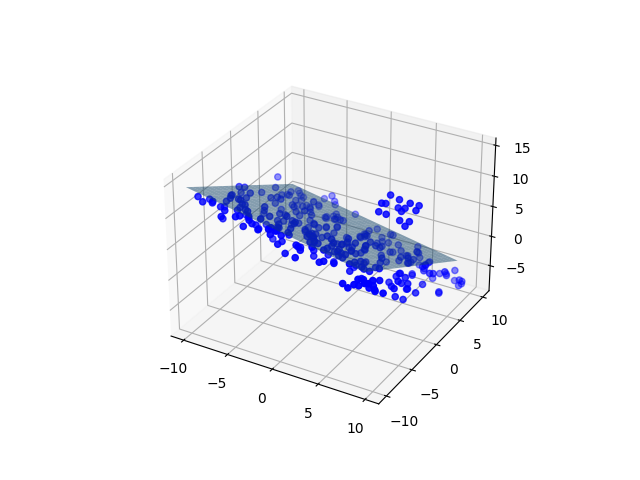

In [18]:
%matplotlib ipympl

ax = plt.figure().add_subplot(projection='3d')

conf = tls(pc2)
plot_3d(ax, pc2, conf, 'b')